In [3]:
# Импортируем нужные для работы библиотеки

import pandas as pd
import json
import pickle
import re

import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Делаем визуальную настройку графиков
sns.set_palette("Set2")
sns.set_theme(style="dark")

import warnings
warnings.filterwarnings('ignore')

## Часть 0. Чтение данных

In [4]:
data ={}
temp = []

# Проходим по 15 файлам дампа НКО (ngo_dump_01.json ... ngo_dump_15.json)
for i in range(1,16):
    
    if i < 10:
       path = f'data/ngo_dump_0{i}.json'
    else:
        path = f'data/ngo_dump_{i}.json' 
        
    # Открываем файл в режиме чтения с UTF-8 кодировкой    
    with open(path, 'r', encoding='utf-8') as f:

            temp = []
            
            for line in f:
                line = line.strip()
                
                if line:
                    obj = json.loads(line)
                    temp.append(obj)
             
            # Сохраняем данные файла в основной словарь с ключом file_X       
            data[f'file_{i}'] = temp
                    


In [5]:
# Создаем пустой DataFrame для объединения всех данных из JSON-файлов
full_df = pd.DataFrame()

for elem in list(data.keys()):
    # Нормализуем JSON-данные из файла в плоский DataFrame
    df = pd.json_normalize(data[elem])
    
    # Конкатенируем текущий DataFrame к общему
    full_df = pd.concat([full_df, df], axis=0)
    full_df = full_df.reset_index(drop=True)
    
full_df.head()

,minjustRegNum,regionName,logo,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,egrulStatus,...,incomeDetail.fedSubsidies.2012.sum,incomeDetail.fedSubsidies.2012.count,incomeDetail.contracts223.2004.sum,incomeDetail.contracts223.2004.count,incomeDetail.fedSubsidies.2007.sum,incomeDetail.fedSubsidies.2007.count,incomeDetail.fedSubsidies.2006.sum,incomeDetail.fedSubsidies.2006.count,incomeDetail.fedSubsidies.2005.sum,incomeDetail.fedSubsidies.2005.count
0,7814061218,Санкт-Петербург,None,МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,NaN,"Объединения (союз, ассоциация) юридических лиц",None,Зарегистрирована,1207800141790,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7714017452,Москва,None,"ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",NaN,Некоммерческий фонд,None,Зарегистрирована,1207700349152,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7814170160,Санкт-Петербург,None,"КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",NaN,Коллегия адвокатов,None,Зарегистрирована,1207800011430,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,Москва,None,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",NaN,None,None,None,1207700348976,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7814052913,Санкт-Петербург,None,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",NaN,Автономная некоммерческая организация,None,Зарегистрирована,1207800081500,Действует,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(f'Полученный датафрейм имеет размерность {full_df.shape}')

Полученный датафрейм имеет размерность (747034, 198)


Создадим функцию, которая визуализирует пропуски данных для болле детального изучения

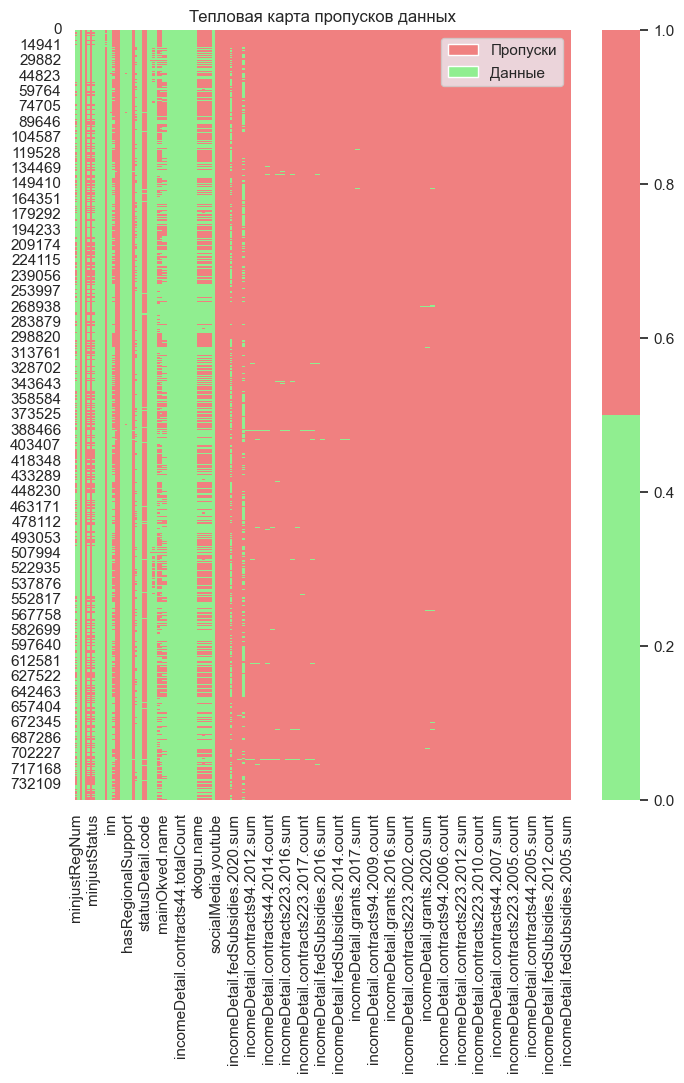

In [7]:
def empty_data_heatmap(df):
    """
    Создает тепловую карту пропусков данных (missing values) в DataFrame.
    
    Args:
        df (pd.DataFrame): Исходный DataFrame для анализа пропусков
        
    Создает визуализацию где:
    - Красный = пропущенные значения (NaN/None)
    - Зеленый = заполненные значения
    """

    # Определяем цветовую схему: красный=пропуски, зеленый=данные
    colors = ['lightgreen', 'lightcoral']

    fig = plt.figure(figsize=(8, 10))
    cols = df.columns
    
    # Создаем heatmap булевой маски пропусков (True=NaN, False=данные)
    ax = sns.heatmap(
        df[cols].isnull(),                    # Матрица пропусков (булева)
        cmap=sns.color_palette(colors),       # Двухцветная палитра
    )
    
    # Создаем кастомную легенду с прямоугольниками и подписями
    legend_elements = [
        Patch(facecolor='lightcoral', label='Пропуски'),
        Patch(facecolor='lightgreen', label='Данные')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right')
    ax.set_title("Тепловая карта пропусков данных")
    plt.show()


empty_data_heatmap(full_df)

In [8]:
# Посмотрим, где больше всего пропусков
full_df.isna().sum().nlargest(20)

logo                                    747034
dateReg                                 747034
charter                                 747034
dateLiquid                              747034
socialMedia.instagram                   747033
incomeDetail.contracts223.2002.sum      747033
incomeDetail.contracts223.2002.count    747033
incomeDetail.fedSubsidies.2008.sum      747033
incomeDetail.fedSubsidies.2008.count    747033
incomeDetail.contracts94.2003.sum       747033
incomeDetail.contracts94.2003.count     747033
incomeDetail.contracts94.2014.sum       747033
incomeDetail.contracts94.2014.count     747033
incomeDetail.contracts44.2002.sum       747033
incomeDetail.contracts44.2002.count     747033
incomeDetail.contracts223.2006.sum      747033
incomeDetail.contracts223.2006.count    747033
incomeDetail.fedSubsidies.2012.sum      747033
incomeDetail.fedSubsidies.2012.count    747033
incomeDetail.contracts223.2004.sum      747033
dtype: int64

## Часть 1. Избавляемся от столбцов с большим числом пропусков

In [9]:
# Создадим список, в который сохраним названия нерелевантных признаков
cols_to_drop = []

In [10]:
# Фильтруем столбцы, исключая те, что содержат 'income' в названии
other_columns = full_df.filter(regex='^(?!income).*').copy()

# Вычисляем процент пропусков для каждого столбца (среднее по оси строк)
# и сортируем по убыванию
cols_null_percent = other_columns.isna().mean() * 100
cols_with_null = cols_null_percent.sort_values(ascending=False).round(1)

pd.DataFrame({
    'Колонка': cols_with_null.index[:20],
    '% пропусков': cols_with_null.values[:20]
    })


,Колонка,% пропусков
0,dateLiquid,100.0
1,logo,100.0
2,dateReg,100.0
3,charter,100.0
4,socialMedia.instagram,100.0
5,socialMedia.ok,100.0
6,socialMedia.twitter,100.0
7,socialMedia.youtube,100.0
8,socialMedia.facebook,100.0
9,socialMedia.vk,100.0


In [11]:
# Добавляем в список столбцов для удаления те, у которых больше 95% пропусков
cols_to_drop.extend(list(cols_with_null[cols_with_null > 95].index))
cols_to_drop = list(set(cols_to_drop))
cols_to_drop


['website',
 'logo',
 'socialMedia.facebook',
 'socialMedia.ok',
 'email',
 'charter',
 'socialMedia.twitter',
 'socialMedia.vk',
 'socialMedia.youtube',
 'statusDetail.code',
 'statusDetail.name',
 'dateLiquid',
 'website_punycode',
 'socialMedia.instagram',
 'dateReg']

Поищем скрытые пропуски: в некоторых признаках данные развернулись не польностью и часть элементов представляет из себя пустые списки:

In [12]:
# Рассмотрим опреденные колонки
columns = ['predecessors', 'successors', 'reports']

# Заменяем пустые списки/массивы на NaN,
full_df[columns] = full_df[columns].where(
    full_df[columns].apply(lambda col: col.apply(len) > 0)
    )

full_df[['predecessors', 'successors', 'reports']].isna().mean() * 100


predecessors    98.462721
successors      98.025123
reports         82.212858
dtype: float64

Добавл в список на удаление *predecessors, successors, reports*, поскольку они содержат гигантское число пропусков.

In [13]:
# Добавим в список на удаление predecessors, successors, reports,
# поскольку они содержат гигантское число пропусков (>82%)
cols_to_drop.extend(['predecessors', 'successors', 'reports'])

## Часть 2. Прочие признаки с пропусками

In [14]:
# Отфильтруем датасет по признакам ОКОГУ, ОКФС и ОКПО 
full_df.filter(regex='^okogu|^okfs|^okpo').isna().mean()*100

okpo          53.491140
okogu.name    53.492612
okogu.code    53.491140
okfs.name     53.491140
okfs.code     53.491140
dtype: float64

Мы видими довольно большой % пропусков в данных по этим факторам

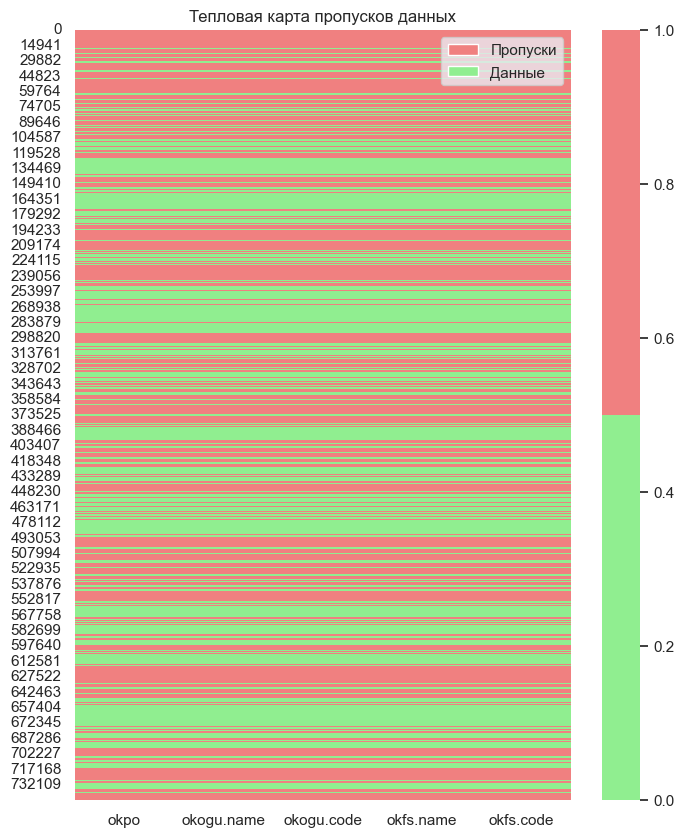

In [15]:
empty_data_heatmap(
    full_df.filter(regex='^okogu|^okfs|^okpo')
)

Сами по себе признаки ОКОГУ, ОКФС и ОКПО могли бы быть полезны для моделей машинного обучения при классификации НКО, но большое количество пропусков (причем в одинх и тех же строчках) не оставляет другого варианта, кроме как удалить эти признаки. В случае, если бы попытались заполнять более 53% пропусков в этих призанаках, то данные получили бы сильное искажение.

In [16]:
# Добавим в список на удаление из датасета ОКОГУ, ОКПО и ОКФС
cols_to_drop.extend(
    full_df.filter(regex='^okogu|^okfs|^okpo').columns.to_list()
)

Дальше рассмотрим признаки ОКТМО и ОКАТО:
 - ОКАТО (Общероссийский классификатор административно-территориального деления) использовался до 2014 года и описывал территориальные единицы по старой структуре.
- ОКТМО (Общероссийский классификатор территориальных единиц муниципальных образований) введен с 2014 года и отражает новую систему муниципальных образований, соответствующую реформе местного самоуправления. 

ОКАТО и ОКТМО относятся к разным периодам и структурам, хотя оба служат для идентификации территорий. 

In [17]:
# Отфильтруем датасет по признакам ОКТМО и ОКАТО
full_df.filter(regex='^oktmo|^okato').isna().mean()*100

oktmo.name    63.092175
oktmo.code    53.491140
okato.name    54.724952
okato.code    53.491140
dtype: float64

Мы видими сущесвенный процент пропусков в данных по этим признакам.

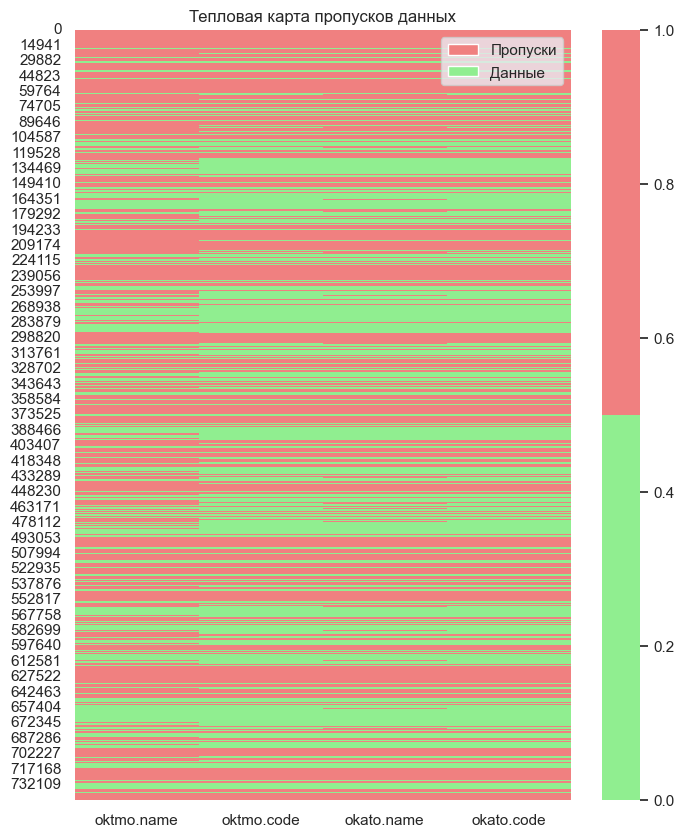

In [18]:
# Посмотрим на признаки ОКТМО и ОКАТО
empty_data_heatmap(
    full_df.filter(regex='^oktmo|^okato')
)

На тепловой карте пропусков видим, что в большинстве случаев, где нет данных ОКАТО, также отсутствуют и данные ОКТМО. Поэтому нет возможности объеденить эти признаки в один более информативный. А поскольку процент пропуска данных в них около 50, то нет смысла оставлять их для дальнейшего анализа.

In [19]:
# # Добавим в список на удаление ОКТМО и ОКАТО из датасета
cols_to_drop.extend(
    full_df.filter(regex='^oktmo|^okato').columns.to_list()
)

## Часть 3. Признаки с информацией о доходах НКО

In [20]:
# Фильтруем данные по ключевого слову income в признаках
income_cols = full_df.filter(regex='^income').columns

print(f'Размерность данных, содержащих детализация сведений о доходах {full_df[income_cols].shape}')

Размерность данных, содержащих детализация сведений о доходах (747034, 145)


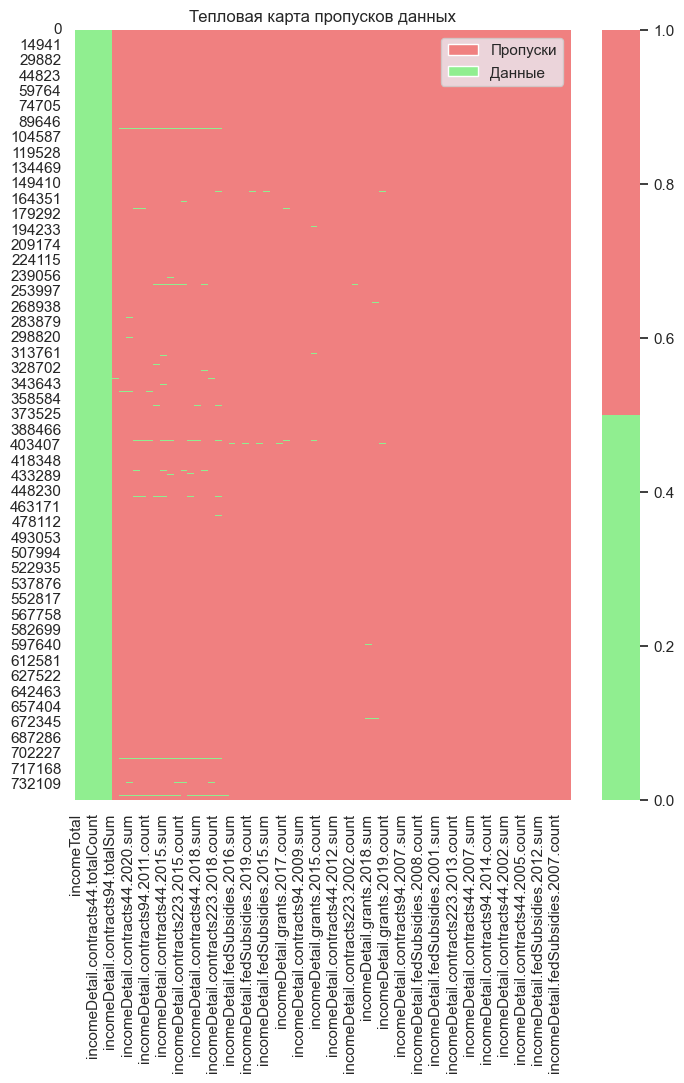

In [21]:
# Фильтруем данные по ключевого слову income в признаках
empty_data_heatmap(full_df.filter(regex='^income'))

Итого мы имеем 145 признаков, большиство из которых имеет более 99 % пропусков. Очевидно, такие факторы придется удалить в дальнейшем. Для начала рассмотрим признаки, в которых нет пропусков.

В датасете есть признак *incomeTotal*: общая сумма доходов из известных источников - контрактов, договоров, президентских грантов, федеральных субсидий. А также есть признаки с данными отдельно по контрактам, грантам и субсидиям. Что избежать утечки данных (data leak) придется остановить свой выбор на чем-то одном.

В брифе к этому проекту рекомендуется просуммировать данные из полей *contracts44, contracts223, contracts94*.

Конечно это разные формы контрактов, но это имеет значение только для заказчика (для государства). Нас интересует сам факт выплат по контракту. 

In [22]:
# Суммируем суммы контрактов по типам 44-ФЗ, 94-ФЗ и 223-ФЗ
contract_columns = [
    'incomeDetail.contracts44.totalSum',
    'incomeDetail.contracts94.totalSum',
    'incomeDetail.contracts223.totalSum'
]

full_df['contractSum'] = full_df[contract_columns].sum(axis=1)

# Создаем бинарный индикатор наличия контрактов
full_df['contractSum'] = (full_df['contractSum'] > 0).astype(int)
full_df['contractSum'].value_counts()


contractSum
0    723369
1     23665
Name: count, dtype: int64

Я умышленно ушел от суммы контракта, посколько задачей проекта является предсказывание самого факта получения госконтракта, а не его сумма. 

Аналогичено поступим с числом контрактов:

In [23]:
# Суммируем количество контрактов по типам 44-ФЗ, 94-ФЗ и 223-ФЗ
contract_count_columns = [
    'incomeDetail.contracts44.totalCount',
    'incomeDetail.contracts94.totalCount',
    'incomeDetail.contracts223.totalCount'
]

# Создаем бинарный индикатор наличия контрактов
full_df['ContractCount'] = full_df[contract_count_columns].sum(axis=1)
full_df['ContractCount'] = (full_df['ContractCount'] > 0).astype(int)
full_df['ContractCount'].value_counts()


ContractCount
0    723285
1     23749
Name: count, dtype: int64

In [24]:
# Проверяем случаи, когда есть контракты по количеству, но нулевая сумма
mask = (full_df['ContractCount'] == 1) & (full_df['contractSum'] == 0)
print(f'Число контрактов с суммой 0 получилось равным {full_df[mask].shape[0]}')

# Проверяем несоответствия между индикаторами количества и суммы контрактов
# Ожидаем, что оба индикатора должны быть равны (0-0 или 1-1)
mask2 = (full_df['ContractCount'] != full_df['contractSum'])
print(f'Данных, где значение ContractCount не равно contractSum: {full_df[mask2].shape[0]}')


Число контрактов с суммой 0 получилось равным 84
Данных, где значение ContractCount не равно contractSum: 84


Можно заметить некоторую аномалию в данных: в них присутствуют данные о контрактах без суммы. Возможно по ним не было оплаты или же данные были потеряны. Но пронозирование суммы контракта не является нашей задачей, число аномальных данных несущественно, то контракты с нулевой суммой мы приравняем обычным контрактам. Поэтому нам нужно избавиться от *contractSum*.

In [25]:
# Добавим в список на удаление contractSum
cols_to_drop.append('contractSum')

Посмотрим на признаки отвечающие за субсидии и гранты

In [26]:
# Отделим данные о выданных грантах и субсидиях в признаки-мигалки
full_df['Subsidies'] = (full_df['incomeDetail.fedSubsidies.totalCount'] > 0).astype(int)
full_df['grants'] = (full_df['incomeDetail.grants.totalCount'] > 0).astype(int)

# Посмотрим какое получилось соотношение
full_df[['Subsidies','grants']].value_counts()

Subsidies  grants
0          0         733524
           1          10624
1          0           2181
           1            705
Name: count, dtype: int64

Грантов было выдано сильно меньше, чем субсидий. Организаций, которые получили от государства оба вида финансирования (и грант, и субсидию) получилось достаточно мало 705 (около 0.1% от общего числа). Поэтому я решил эти признаки объеденить в один общий  - Grants & Subsidies. Напомню, что одна из задач проекта - это опредилить зависимость вероятности получения грантов от государства. Далее под грантом будет подразумеваться именно объедененный признак субсидий и грантов.

In [27]:
full_df['Grants & Subsidies'] = full_df['Subsidies'] + full_df['grants']
full_df['Grants & Subsidies'] = full_df['Grants & Subsidies'].astype(int)
display(full_df['Grants & Subsidies'].value_counts(normalize=True)*100)

# Удаляем ненужные призанки
cols_to_drop.extend(['Subsidies', 'grants'])

Grants & Subsidies
0    98.191515
1     1.714112
2     0.094373
Name: proportion, dtype: float64

Как и отмечалось ранее мы имеем множество признаков по типу incomeDetail.fedSubsidies.2005.sum, в которых большинство значений - пустые. Такие признаки будут удалены, но перед этим создадим признак года, в который было совершено целевое действие: выплата от государства. Если таких действий было несколько (например, выплаты по двум контрактам и выплата по гранту), то для упрощения задачи мы будет брать лишь дату (год) первой выплаты.

In [28]:
# Извлекаем столбцы с годом: incomeDetail.*.YYYY.count
year_cols = full_df.filter(
    regex=r'incomeDetail\.\w+\.\d{4}\.count'
).columns.tolist()

def get_years_list(row):    
    """
    Извлекает год ПЕРВОГО получения госдоходов по НКО.
    
    Args:
        row: строка DataFrame с данными по годам контрактов/грантов
        
    Returns:
        int: минимальный год получения доходов или None (нет доходов)
    """
    years = []
    
    for col in year_cols:
        
        if pd.notna(row[col]) and row[col] != 0:
            # Извлекаем год из имени столбца: incomeDetail.contracts44.2014.count
            year = int(col.split('.')[2])
            years.append(year)
    
    if years:
        
        # Минимальный год = первый раз получили госдоходы
        return min(years)
    
    else:
        return 

# Работает с копией датафрейма для увеличения производительности
df_copy = full_df[year_cols].copy()
df_copy['years_income'] = df_copy.apply(get_years_list, axis=1)

# Год с значением 0 будет подразумевать отсутствие гранта/контракта
df_copy['years_income'] = df_copy['years_income'].fillna(0)
full_df['years_income'] = df_copy['years_income'].astype(int)
df_copy['years_income'].value_counts()

years_income
0.0       712637
2011.0      5427
2015.0      3804
2013.0      3533
2017.0      3501
2020.0      3085
2014.0      2995
2018.0      2893
2016.0      2866
2012.0      2690
2019.0      2425
2010.0       606
2021.0       332
2009.0        99
2008.0        80
2007.0        41
2005.0         6
2006.0         5
2001.0         5
2002.0         2
2003.0         1
2004.0         1
Name: count, dtype: int64

In [29]:
# Удаляем из датасета признаки с income:
cols_to_drop.extend(income_cols)

full_df.drop(cols_to_drop, axis=1).columns

Index(['minjustRegNum', 'regionName', 'fullName', 'minjustForm',
       'minjustStatus', 'ogrn', 'egrulStatus', 'regionCode', 'administrators',
       'inn', 'address', 'kpp', 'hasRegionalSupport', 'addOkved', 'shortName',
       'statusDetail.shortName', 'opf.name', 'opf.code', 'opf.version',
       'mainOkved.name', 'mainOkved.code', 'mainOkved.version',
       'originDate.$date', 'dateOgrn.$date', 'dateLiquid.$date',
       'dateReg.$date', 'ContractCount', 'Grants & Subsidies', 'years_income'],
      dtype='object')

# Часть 4. Данные из Минюста

Посмотрим, что представляют собой признаки, начинаюшиеся на *minjust*

In [30]:
print('Процент пропусков в данных:')
display(full_df.filter(regex='^minjust').isna().mean()*100)

print(f"Число уникальных значений для minjustRegNum равно {full_df['minjustRegNum'].nunique()}")
display(full_df.filter(regex='^minjust').head())

Процент пропусков в данных:


minjustRegNum    38.114999
minjustForm      38.114999
minjustStatus    38.114999
dtype: float64

Число уникальных значений для minjustRegNum равно 461971


,minjustRegNum,minjustForm,minjustStatus
0,7814061218,"Объединения (союз, ассоциация) юридических лиц",Зарегистрирована
1,7714017452,Некоммерческий фонд,Зарегистрирована
2,7814170160,Коллегия адвокатов,Зарегистрирована
3,None,None,None
4,7814052913,Автономная некоммерческая организация,Зарегистрирована


*minjustRegNum* представляет собой реестровый номер НКО в системе Минюста. Очевидно, что это технический набор цифр, которые нужен только самому Минюсту для ведения отчетности. Такие данные будут скорее вредны модели, поскольку они больше похожи на шум, где большинство значений уникальные.

In [31]:
# Удаляем ненужный признак
cols_to_drop.append('minjustRegNum')

Посмотрим на *minjustForm* в разрезе признака получения грантов от государства/госконтрактов.

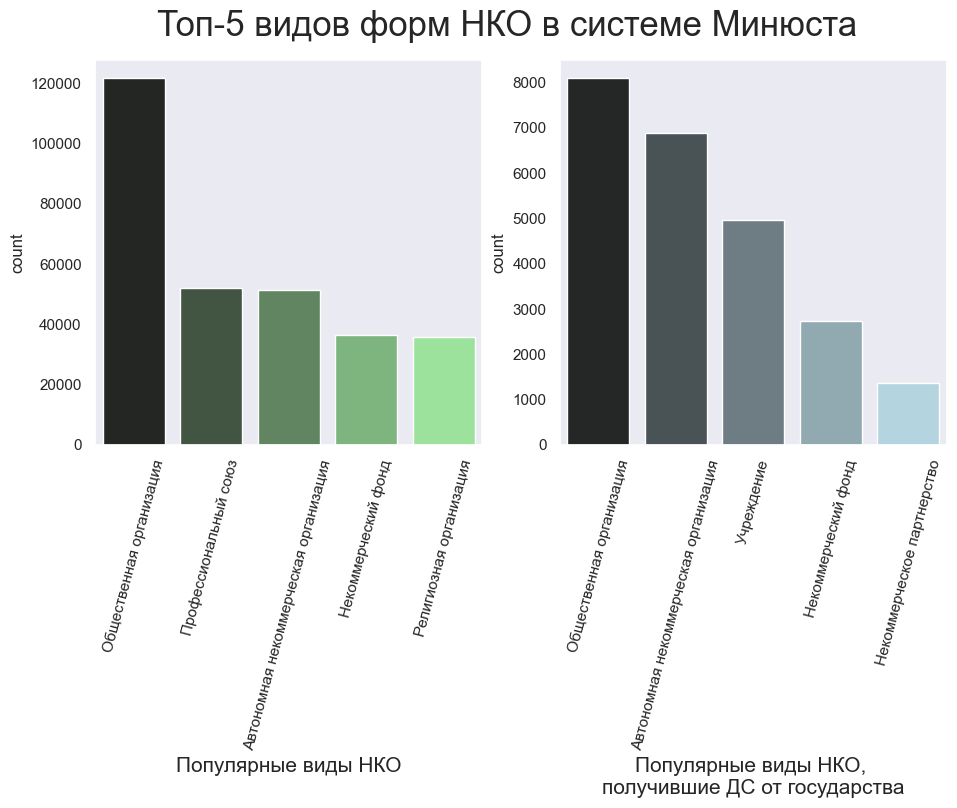

In [32]:
# Сделаем маску НКО, которые получили денежные срества от государства
mask = (full_df['incomeTotal']>0)

# Визуализируем столбчатой диаграммой соотношение minjustForm
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Топ-5 видов форм НКО в системе Минюста', size=25)

sns.barplot(data=full_df['minjustForm'].value_counts().nlargest(5).reset_index(name='count'),
             x='minjustForm', y='count', ax=ax[0],  palette='dark:lightgreen')

ax[0].tick_params(axis='x', rotation=75)
ax[0].set_xlabel('Популярные виды НКО', size=15)

sns.barplot(full_df[mask]['minjustForm'].value_counts().nlargest(5).reset_index(name='count'),
             y='count', x='minjustForm', ax=ax[1], palette='dark:lightblue')

ax[1].tick_params(axis='x', rotation=75)
ax[1].set_xlabel('''Популярные виды НКО, 
получившие ДС от государства''', size=15);

Видим, что фактор *minjustForm (вид НКО в системе Минюста)* оказывает некоторое влияние на получение НКО контракта или гранта от государства. Значит, что несмотря на большое число пропусков (около 38%) стоит попробовать заполнить их. Для этого обратимся к сайту Министерства Юстиций России и будем искать информацию по ОГРН организации.

In [33]:
# Посмотрим какие значения принимает minjustForm:
other_columns[mask]['minjustForm'].value_counts().nlargest(15)

minjustForm
Общественная организация                                8093
Автономная некоммерческая организация                   6891
Учреждение                                              4967
Некоммерческий фонд                                     2737
Некоммерческое партнерство                              1369
Объединения (союз, ассоциация) юридических лиц          1199
Товарищество собственников жилья                        1121
                                                         868
Религиозная организация                                  513
Профессиональный союз                                    457
Общественный фонд                                        357
Общественно-государственное общественное объединение     269
Общественное движение                                    252
Казачье общество                                         224
Коллегия адвокатов                                       174
Name: count, dtype: int64

На 8 по полулярности месте вид НКО - пустая строка. Это скрытые пропуски в данных, их нужно заполнить

In [34]:
# Напишем специльную функцию, которая по значению ОГРН будет находить
# на сайте Минюста форму для НКО

import time
import random
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def find_nko_form(ogrn):

    # Серверы часто блокируют запросы без User-Agent или с нестандартными значениями, чтобы защититься от ботов.
    # Подставляя строку настоящего браузера, мы имитируем обычного пользователя, и сервер разрешает доступ к данным.
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    url = 'https://nco.minjust.gov.ru/ru/registries?ogrn='   
    
    link = url+ogrn
    
    # Создаем сессию requests для переиспользования соединений
    session = requests.Session()
    
    # Настраиваем стратегию повторных попыток при сбоях сети
    retry_strategy = Retry(
        total=3,
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
    )
    
    # Подключаем адаптер с retry-логикой к сессии
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    try:
        # Задержка между запросами
        time.sleep(random.uniform(1, 3))
        
        # Выполняем GET-запрос с таймаутами и отключенной проверкой SSL (для проблемных сертификатов)
        response = session.get(link, headers=headers, verify=False, timeout=(10, 30))  
        response.raise_for_status()
        
        # Парсим HTML-страницу с помощью BeautifulSoup
        page = BeautifulSoup(response.text, 'html.parser')
        nko_form = page.find('td', class_='px-4 py-2 text-start align-top w-11/10')
        
        return nko_form.text.strip() if nko_form else ''
        
    # Обработка таймаута подключения/чтения
    except requests.exceptions.Timeout:
        print(f"Timeout для ОГРН {ogrn}")
        return ''
        
    # Обработка всех остальных сетевых ошибок (DNS, соединение, HTTP ошибки)
    except requests.exceptions.RequestException as e:
        print(f"Ошибка для ОГРН {ogrn}: {e}")
        return ''
        

    finally:
        session.close()

In [35]:
# Проверим как рабоает новая функция
a = full_df.query("minjustForm == '' ")['ogrn'].iloc[:20].map(find_nko_form)
a.value_counts()

ogrn
Общественная организация                                5
Автономная некоммерческая организация                   4
Объединения (союз, ассоциация) юридических лиц          3
Некоммерческий фонд                                     2
Общественно-государственное общественное объединение    2
Фонд                                                    2
Учреждение                                              1
Религиозная организация                                 1
Name: count, dtype: int64

Все работает корректно, можно заменять данные во всем датасете. Едиственное, что на обработку каждой строки уходит около 2х секунд, то есть для 1200 строк понадобится примерно 40 минут. 

Для ускорения чтения данных будем использовать модуль *futures* стандартной библитеки *concurrent*. Она предоставляет высокоуровневый интерфейс для асинхронного выполнения задач в *Python* с помощью пулов потоков (*ThreadPoolExecutor*) или процессов (*ProcessPoolExecutor*). Она позволяет запускать функции параллельно, что значительно ускоряет выполнение операций, особенно при работе с HTTP-запросами.

In [36]:
# Получаем список ОГРН пустых строк
empty_ogrn = full_df.query("minjustForm == '' ")['ogrn'].tolist()

# Запускаем параллельно
with ThreadPoolExecutor(max_workers=15) as executor:
    results = list(executor.map(find_nko_form, empty_ogrn))

# Заполняем пустые строки
full_df.loc[full_df["minjustForm"] == '', "minjustForm"] = results

In [37]:
# Заполним вручную где не справился скрипт

full_df.loc[full_df["ogrn"] == '1037200036004', "minjustForm"] = 'Казачье общество'

Заполним также пропуски в классичеком понимании данными из Минюста. Для этого я запускал скрип на всех пропусках и он работал более 11 часов. Поэтому я сохранил в файл список номеров огрн, данные по которым есть на сайте Минюста. Там всего 941 значение из 284732 обшего числа пропусков. Прочитаем этот файл и заполним пропуски с помощью функции find_nko_form

In [38]:
ogrn_list = pd.read_excel('data/ogrn__list.xlsx').astype(str)
ogrn_list = ogrn_list['Col'].tolist()

with ThreadPoolExecutor(max_workers=15) as executor:
    results = list(executor.map(find_nko_form, ogrn_list))
    
# Заполняем пропущенные значения
full_df.loc[full_df["ogrn"].isin(ogrn_list), "minjustForm"] = results

In [39]:
# Для парсинга и нахождения статуса НКО напишем похожую функцию

def find_nko_status(ogrn):

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    url = 'https://nco.minjust.gov.ru/ru/registries?ogrn='   
    
    link = url+ogrn

    # Для парсинга используем библиотеки requests и BeautifulSoup
    response = requests.get(link, headers=headers, verify=False)
    page = BeautifulSoup(response.text, 'html.parser') 
        
    nko_status = page.find_all('td', class_="px-4 py-2 text-start align-top w-1/6")

    if nko_status:
        return nko_status[1].text
    
    else:
        print(f'Для {ogrn =} не получилось найти данные')
        return '-'


In [40]:
ogrn_list = pd.read_excel('data/ogrn__list.xlsx').astype(str)
ogrn_list = ogrn_list['Col'].tolist()

with ThreadPoolExecutor(max_workers=15) as executor:
    results = list(executor.map(find_nko_status, ogrn_list))
    
# Заполняем пропущенные значения
full_df.loc[full_df["ogrn"].isin(ogrn_list), "minjustStatus"] = results


Остались организации, которые не представлены на сайте Минюста. Заполним пропуски на 'Нет данных', чтобы можно было использовать эти признаки в дальнейнем.

In [41]:
full_df['minjustStatus'].fillna('Нет данных', inplace=True)
full_df['minjustForm'].fillna('Нет данных', inplace=True)

# Часть 5. Общероссийский классификатор видов экономической деятельности (ОКВЭД)

In [42]:
#  Фильтруем данные по ключевого слову Okved в признаках
Okved = full_df.filter(regex='Okved', axis=1).copy()

Okved.isna().sum()

addOkved                  0
mainOkved.name       204681
mainOkved.code       204681
mainOkved.version         0
dtype: int64

В стобце *addOkved* присутствуют скрытые пропуски - пустые списки.

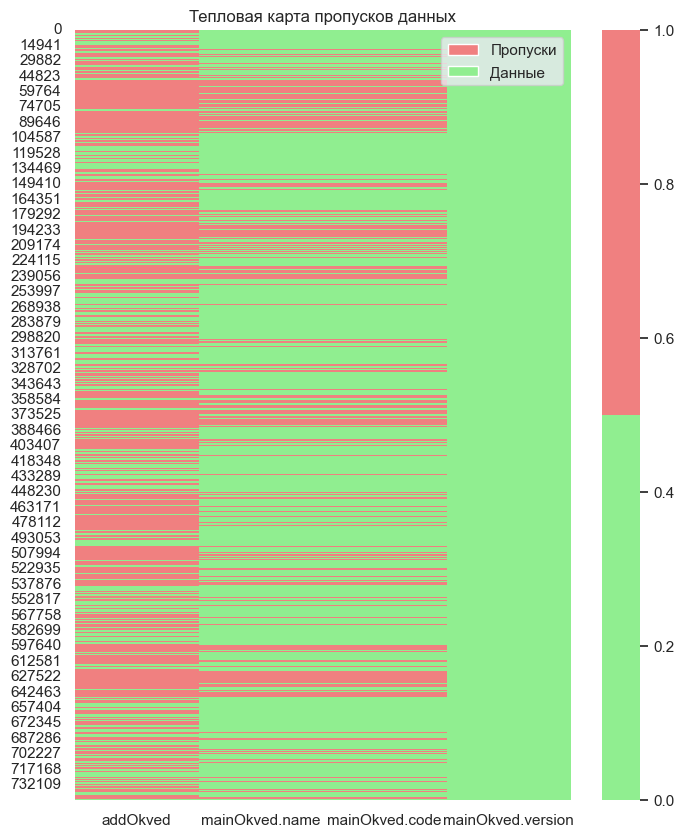

In [43]:
# Заменяем пустые списки/массивы на NaN,
Okved[['addOkved']] = Okved[['addOkved']].where(
    Okved[['addOkved']].apply(lambda col: col.apply(len) > 0)
    )

empty_data_heatmap(Okved)

Заполним пропуски в сведениях об основном ОКВЭД, там где это возможно. Для это будем использовать *addOkved* (дополнительный ОКВЭД). После этого удалим его, потому что пропусков в нем слишком много.

In [44]:
# Создадим маску для пропусков из mainOkved.code, но с непустыми значениями addOkved
mask = (Okved['mainOkved.code'].isna()) & (Okved['addOkved'].notna())
Okved[mask].shape

(205, 4)

Всего мы можем заполнить 205 пропусков для *mainOkved.code* и *mainOkved.name*. Поскольку у некоторых НКО может быть несколько дополнительных ОКВЭД, то будем брать лишь 1 значение из списка.

In [45]:
# Получаем индексы и данные для маскированных строк
original_index = Okved[mask].index
add_okved_data = Okved.loc[mask, 'addOkved']

# Извлекаем первый элемент из каждого списка и нормализуем JSON
first_items = add_okved_data.map(lambda x: x[0])
normalized_df = pd.json_normalize(first_items)
normalized_df.index = original_index

# Обновляем основной датафрейм полями из нормализованных данных
full_df.loc[original_index, 'mainOkved.name'] = normalized_df.loc[original_index, 'name']
full_df.loc[original_index, 'mainOkved.code'] = normalized_df.loc[original_index, 'code']



В данных по ОКВЭД сохраняется значительное количество пропусков (более 204 тыс. строк). Заполнение их вручную или через API оказалось трудоемким и экономически нецелесообразным процессом.

Пропуски в *mainOkved.name* и *mainOkved.code* строго коррелируют — отсутствие значения в одном поле гарантирует пропуск и в другом. Простая замена на "Нет данных" неприемлема, поскольку исказит анализ зависимости целевых показателей от вида экономической деятельности — ключевого фактора проекта. Поэтому оптимальным решением стало исключение строк с пропусками в этих полях.


In [46]:
# Удаляем строки с пропусками в ключевых полях ОКВЭД
full_df = full_df.dropna(subset=['mainOkved.version', 'mainOkved.code'])

# Добавляем в список на удаление ненужный более признак
cols_to_drop.append('addOkved')


In [47]:
# Рассмотрим признак mainOkved.version - версии основного ОКВЭД
df['mainOkved.version'].value_counts()

mainOkved.version
ОК 029-2001 (КДЕС Ред. 1)    25792
ОК 029-2014 (КДЕС Ред. 2)    24208
Name: count, dtype: int64

ОК 029-2001 (КДЕС Ред. 1) - версия ОКВЭД 1 (НКО зарегестривана до 2017)
ОК 029-2014 (КДЕС Ред. 2) - версия ОКВЭД 2 (НКО зарегестрирована после 2014)

Признак косвенно отражает дату регистрации и "свежесть" данных ЕГРЮЛ

In [48]:
# Создадим признак is_new_okved как прокси для "старые/новые" компании
full_df['is_new_okved'] = (full_df['mainOkved.version'] == 'ОК 029-2014 (КДЕС Ред. 2)').astype(int)
cols_to_drop.append('mainOkved.version')

# Часть 6. Cведения об организационно-правовой форме организации

Посмотрим на столбцы с ОПФ:

In [49]:
full_df.filter(regex='^opf').head()

,opf.name,opf.code,opf.version
0,Ассоциации (союзы),20600,okopf
1,Фонды,70400,okopf
2,Коллегии адвокатов,20616,okopf
3,Товарищества собственников недвижимости,20700,okopf
4,Автономные некоммерческие организации,71400,okopf


In [50]:
# Пропуски в ОПФ
full_df.filter(regex='^opf').isna().sum()

opf.name          25
opf.code       26434
opf.version       25
dtype: int64

Признак *opf.version* (версия классификатора ОПФ) принимает всего 3 значения okopf, raw_opf, kopf

Признак opf.version дублирует информацию об организационно-правовой форме, но не несет дополнительной смысловой нагрузки, поскольку все его значения (okopf, raw_opf, kopf) относятся к одному и тому же классификатору ОПФ, но в разных форматах или источниках. ОКОПФ — это официальный код, raw_opf — исходное (необработанное) значение, а kopf — устаревшее название классификатора. Удаление opf.version упростит модель и повысит интерпретируемость, не потеряв при этом полезные данные.

*opf.code* (код ОПФ) и *opf.name* (расшифровка кода ОПФ) — это разные способы обозначения одной и той же организационно-правовой формы, но они отличаются по назначению и формату.
​
- Каждому коду ОКОПФ соответствует только одно наименование ОПФ и наоборот, но код применяется в технических и отчетных целях, а наименование — для удобства восприятия человеком

- Признак opf.code — это пятизначный числовой код ОКОПФ, который несет ту же информацию, но в менее удобном формате, а также имеет значительно больше пропусков (45209 против 415 у opf.name), что снижает его полезность для анализа.

Таким образом, удаление opf.code не приводит к потере значимой информации, но упрощает работу с данными и повышает их качество за счет снижения количества пропусков.

In [51]:
# Удаляем признаки
cols_to_drop.extend(['opf.code', 'opf.version'])

In [52]:
# Заполним пропуски с помощью api сервиса Dadata
# Он выгружает данные  из ЕГРЮЛ о компании по ОГРН

from dadata import Dadata
token = "846481f414a88539d327646bac9632856ed73f39"
dadata = Dadata(token)
i = 0

for ogrn in full_df[full_df['opf.name'].isna()]['ogrn']:
    
    result = dadata.suggest("party", ogrn)
    
    # Если по ключю opf в базе есть данные
    if result[0]['data']['opf']: 
        opf_name = result[0]['data']['opf']['full']
        full_df.loc[full_df['ogrn'] == ogrn, 'opf.name'] = opf_name

        i += 1

print(f'С помощью Api Dadata нам удалось заполнить {i} пропусков')
full_df['opf.name'] = full_df['opf.name'].fillna('Нет данных')


С помощью Api Dadata нам удалось заполнить 3 пропусков


При детальном рассмотрении призанака *opf.name* было обнаружено множество явных дублей и близких значений. Попытаемся избавиться от излишней вариативности признака ниже:

In [53]:
# Напишем функцию для обработки признака opf.name:

def opf_name_transform(opf_name):

    """
    Нормализует названия организационно-правовых форм (ОПФ).
    
    Args:
        opf_name: исходное название ОПФ (строка)
        
    Returns:
        str: стандартизированная категория ОПФ или 'нет данных'
    """
        
    opf_name = opf_name.lower()
    
    exclusion_list = [
        'опф отсутствует в реестре',
        'иное',
        'иные формы',
        'lдругие предприятия',
        'не выбрано'
    ]
    
    if opf_name in exclusion_list or re.findall(r'\bдруг\w*\b', opf_name):
        return 'нет данных'
        
    if re.findall(r'\bфонд\w*\b', opf_name):
        return 'фонд'
    
    if re.findall(r'\bакцион\w*\b', opf_name):
        return 'акционерное общество'
    
    if re.findall(r'\bкооператив\w*\b', opf_name):
        return 'кооператив'
    
    if re.findall(r'\bобщин\w*\b', opf_name):
        return 'община'
    
    if re.findall(r'\bсамодеятель\w*\b', opf_name):
        return 'орган общественной самодеятельности'
    
    if re.findall(r'\bтовариществ\w*\b', opf_name):
        return 'товарищество'
    
    if re.findall(r'\bказа\w*\b', opf_name):
        return 'казачье общество'
    
    if re.findall(r'\bрелиг\w*\b', opf_name):
        return 'религиозная организация'
    
    if re.findall(r'\bпартнерств\w*\b', opf_name):
        return 'партнерство'
    
    if re.findall(r'\bуч\w*\b', opf_name):
        return 'учреждение'
    
    if re.findall(r'\b(?:нотар\w*|адвокат\w*)\b', opf_name):
        return 'адвокатское бюро'
    
    if re.findall(r'\b(?:союз\w*|ассоциаци\w*|объединен\w*)\b', opf_name):
        return 'ассоциация'
    
    if re.findall(r'\bпредпри\w*\b', opf_name):
        return 'предприятие'
    
    if re.findall(r'\bсамоуправ\w*\b', opf_name):
        return 'общественное самоуправление'
    
    if re.findall(r'\bполит\w*\b', opf_name):
        return 'политическая партия'
    
    if re.findall(r'\b(?:колхоз\w*\b|фермерс\w*)', opf_name):
        return 'колхоз'
        
    if re.findall(r'\bнеком\w*\b', opf_name):
        return 'некоммерческая организация'

    if re.findall(r'\bкорпорац\w*\b', opf_name):
        return 'государственная корпорация'
    
    if re.findall(r'\bдвижени\w*\b', opf_name):
        return 'общественное движение'

    if re.findall(r'\bобществ\w+\b(?:\s+\w+)*?\s+\bорганиз\w+\b', opf_name) or opf_name == 'общественная':
        return 'общественная организация'

    if re.findall(r'\b(?:профсоюз\w*)', opf_name):
        return 'профсоюзные организации'

    if re.findall(r'\b(?:обществ\w* об\w*)', opf_name):
        return 'общественное объединение'

    if re.findall(r'\b(?:потребительск\w* обществ\w*)', opf_name):
        return 'потребительские общества'

    if re.findall(r'\b(?:торгово-промыш\w* палат\w*)', opf_name):
        return 'торгово-промышленные палаты'

    return opf_name.capitalize()

        

In [54]:
print(f"Было {full_df['opf.name'].nunique()} уникальных значений")

full_df['opf.name'] = full_df['opf.name'].apply(opf_name_transform)
print(f"А стало {full_df['opf.name'].nunique()}")



Было 218 уникальных значений
А стало 35


# Часть 7. Регион регистрации организаций

In [55]:
# Смотрим на число пропусков
full_df.filter(regex='^region').isna().sum()

regionName    9
regionCode    0
dtype: int64

In [56]:
# Посмотрим на уникальные названия регионов
full_df['regionName'].unique()

array(['Санкт-Петербург', 'Москва', 'Республика Марий Эл',
       'Забайкальский край', 'Краснодарский край', 'Кировская область',
       'Астраханская область', 'Республика Алтай', 'Московская область',
       'Пензенская область', 'Томская область', 'Тюменская область',
       'Тверская область', 'Волгоградская область',
       'Свердловская область', 'Камчатский край', 'Владимирская область',
       'Ямало-Ненецкий автономный округ', 'Ставропольский край',
       'Саратовская область', 'Ленинградская область',
       'Ульяновская область', 'Пермский край', 'Оренбургская область',
       'Мурманская область', 'Севастополь', 'Ростовская область',
       'Иркутская область', 'Липецкая область', 'Удмуртская республика',
       'Республика Башкортостан', 'Республика Мордовия',
       'Республика Дагестан', 'Ярославская область',
       'Сахалинская область', 'Хабаровский край', 'Республика Адыгея',
       'Красноярский край', 'Калининградская область',
       'Кемеровская область', 'Челя

Опять видим скрытые пропуски: 'Не определено', а также None. Заполним их ниже:

In [57]:
from collections import Counter

# Словарь для хранения регионов по ОГРН
region_dict = {}

# Маска для строк, где regionName отсутствует или равно 'Не определено'
mask = (full_df['regionName'].isna()) | (full_df['regionName'] == 'Не определено')

# Перебираем ОГРН, удовлетворяющие маске
for ogrn in full_df.loc[mask, 'ogrn']:
    # Запрашиваем данные через Dadata API
    result = dadata.suggest("party", ogrn)
    # Сохраняем регион для текущего ОГРН
    region_dict[ogrn] = result[0]['data']['address']['data']['region_with_type']

# Подсчет количества встречаемых регионов
Counter(region_dict.values())

Counter({'г Байконур': 68, 'Респ Татарстан': 9})

Для единого формата при заполнении пропусков нужно будет преобразовать 'Респ Татарстан' в 'Республика Татарстан'.

In [58]:
# Функция для заполнения пропусков в RegionName
def regionname_fillna(ogrn):
    
    temp = region_dict[ogrn].split()[1]
    
    if temp == 'Татарстан':
        return 'Республика Татарстан'
    
    else:
        return temp
    
full_df.loc[mask, 'regionName'] = full_df.loc[mask, 'ogrn'].apply(regionname_fillna)

После заполнения пропусков сравним *regionCode* и *regionName*. Судя по описанию эти признаки дублируют друга. Проверим так ли это.

In [59]:
# Преобразуем regionCode в целое число 
full_df['regionCode'] = full_df['regionCode'].astype(int)

# Проверяем уникальность regionName для каждого regionCode
# nunique() = 1 означает идеальное соответствие (1 код → 1 название)
full_df.groupby('regionCode')['regionName'].nunique().sort_values(ascending=False)

regionCode
0     1
59    1
68    1
67    1
66    1
     ..
29    1
28    1
27    1
26    1
99    1
Name: regionName, Length: 93, dtype: int64

Каждый regionCode имеет строго 1 *regionName*. Как и следует из описания признаков - в логическом смысле они дублируют друг друга. В дальнейшем мы избавимся от *regionName*, но пока он можем быть полезен для разведовательного анализа данных

# Часть 8. Столбцы с датами

In [60]:
date_cols = ['originDate.$date', 'dateOgrn.$date', 'dateLiquid.$date', 'dateReg.$date']

#full_df[date_cols] = full_df1[date_cols]
print('Пропуски в столбцах с датами')
display(full_df[date_cols].isna().sum())

for col in date_cols:
    full_df[col] = pd.to_datetime(full_df[col], errors='coerce').dt.year

full_df[date_cols].corr()

Пропуски в столбцах с датами


originDate.$date         0
dateOgrn.$date           0
dateLiquid.$date    333193
dateReg.$date       395366
dtype: int64

,originDate.$date,dateOgrn.$date,dateLiquid.$date,dateReg.$date
originDate.$date,1.000000,0.813008,0.364344,1.000000
dateOgrn.$date,0.813008,1.000000,0.427160,-0.011415
dateLiquid.$date,0.364344,0.427160,1.000000,0.020291
dateReg.$date,1.000000,-0.011415,0.020291,1.000000


Видим, что с *originDate.$date* (год основания) полная корреляция с *dateReg.$date* (датой регистрации организаций). Но поскольку во втором признаке есть пропуски, то удалим именно его. Высокая корреляция также у года основания и *dateOgrn.$date* (дата присвоения ОГРН - начиная с 2002 года). Ввиду этого, а также малой информативности второго признака удаляем именно его

In [61]:
cols_to_drop.extend(['dateReg.$date', 'dateOgrn.$date'])

# Часть 9. Статус ЕГРЮЛ и прочие признаки

In [62]:
# Посмотрим на признаки *statusDetail.shortName* и *egrulStatus*.
# Для первого нет тестового описания, а второй - статус организации на основании данных ЕГРЮЛ.

display(df['statusDetail.shortName'].value_counts())
display(df['egrulStatus'].value_counts())

statusDetail.shortName
Действующая                48804
Ликвидируется                557
Недействующая                552
В состоянии банкротства       45
Реорганизуется                42
Name: count, dtype: int64

egrulStatus
Ликвидирована    33155
Действует        16845
Name: count, dtype: int64

По значениям видим, что признаки означают по сути одно и то же - статус НКО. Для признака *egrulStatus* соотношение действующих и ликвидированных организаций примерно одиннаковое, в то время как для *statusDetail.shortName* наоборот - почти 98% считаются действующими. Очевидно, что это признаки противоречат друг другу, что может помешать дальнешнему анализу. Было принято решение удалить именно первый признак - *statusDetail.shortName*, во-первых потому что у нас нет описания признака, а во-вторых при выборочной проверке организаций по ЕГРЮЛ большое число якобы действующих НКО на деле являются ликвидированными.

In [63]:
# Добавляем в список на удаление statusDetail.shortName
cols_to_drop.append('statusDetail.shortName')

full_df['egrulStatus'] =(full_df['egrulStatus'] == 'Ликвидирована').astype(int)

# # Если нет даты ликвидации, значит организацию стоит считатать активной
# Заменим нулями все отсутствующие даты ликвидации
full_df['dateLiquid.$date'].fillna(0, inplace=True)

full_df['originDate.$date'] = full_df['originDate.$date'].astype(int)
full_df['dateLiquid.$date'] = full_df['dateLiquid.$date'].astype(int)

Посмотрим на оставшиеся текстовые столбцы. Нам не нужен точный адресс компании *address* , потому что у нас есть название региона, а название улице не имеет значения для нашей задачи. Для анализа малополезынми являются сами названия организаций: *fullName* и *shortName*, поскольку у нас есть огрн, который уникален для каждой из представленных НКО. Эти тестовые данные полезны для человеческого восприятия информации, но никак не для моделей машинного обучения.

In [64]:
# Добавляем признаки в список на удаление
cols_to_drop.extend(['address', 'fullName', 'shortName'])

In [65]:
# Переименуем некоторые столбцы для ясности
full_df.rename(columns={
    'dateLiquid.$date': 'liquidation_year',
    'originDate.$date': 'registration_year',
    'egrulStatus': 'is_liquidated',
    'ContractCount': 'Contracts'  
    }, inplace=True)

Удаляем ИНН и КПП как реквизитные данные, которые могут навести ML-модель на ложный след и создать мусорные корреляции.Аналогия для понимания:
Представьте двух людей: у одного номер банковской карты начинается с 1, у другого — с 2. Заключение, что второй "в 2 раза успешнее", будет нелепым и статистически ложным. Точно так же ИНН/КПП — это административные артефакты, не связанные с экономической деятельностью.

In [66]:
cols_to_drop.extend(['inn', 'kpp'])

# Часть 10. Руководители организации (administrators)

In [67]:
full_df['administrators'].iloc[0]

[{'name': 'КОШЕЧКИН ДЕНИС ВИКТОРОВИЧ', 'title': 'ПРЕДСЕДАТЕЛЬ ПРАВЛЕНИЯ'}]

Признак *administrators* представлен в виде списка, где name - имя руководителя, а title - должность руководителя.
Имя нам ничего не даст, а вот должность может пригодиться для дальнейшего анализа.

In [68]:
# Извлекаем должность руководителя
full_df['admin_title'] = (
    full_df['administrators']
    .map(lambda x: None if str(x) == '[]' else x[0]['title'].lower())
)

In [69]:
# Посмотрим на популярные должности в датасете
full_df['admin_title'].value_counts().nlargest(15)

admin_title
председатель                            141000
председатель правления                   85083
директор                                 68797
президент                                41871
ликвидатор                               36375
генеральный директор                     16684
председатель совета                      12775
настоятель                               12354
руководитель ликвидационной комиссии     12163
исполнительный директор                   9691
председатель ликвидационной комиссии      7271
председатель кооператива                  6882
председатель правления тсж                3605
атаман                                    3148
конкурсный управляющий                    2760
Name: count, dtype: int64

Склеим в одну строку все должности, что посчитать самые частоту каждого слова из должностей руководителей.

In [70]:
# Объединяем все должности в одну строку
all_titles = ' '.join(
    full_df['admin_title']
    .dropna()
    .astype(str)
    .str.lower()  # ← .str accessor для Series!
    .str.split(expand=True).stack()
)

# Подсчитываем частоту каждого слова и берём топ-50
top70_titles = pd.Series(all_titles.split()).value_counts()[:70]

top70_titles.index


Index(['председатель', 'директор', 'правления', 'президент', 'ликвидатор',
       'совета', 'комиссии', 'ликвидационной', 'руководитель', 'генеральный',
       'настоятель', 'исполнительный', 'кооператива', 'регионального',
       'приходского', 'управляющий', 'отделения', 'тсж', 'организации',
       'атаман', 'фонда', 'комитета', 'конкурсный', 'лица', 'юридического',
       'товарищества', 'пастор', 'настоятель,', 'профкома', 'ректор',
       'председателя', 'начальник', 'секретарь', 'имам-хатыб', 'имам-хатыйб',
       'президиума', 'заместитель', 'коллегии', 'партии', 'профсоюзного',
       'федерации', 'профсоюзной', 'имам', 'партнерства', 'обязанности',
       'исполняющий', 'главный', 'общины', 'ассоциации', 'партнер',
       'политического', 'первичной', 'жск', 'и', 'вице-президент', 'пресвитер',
       'гск', 'профсоюза', 'координационного', 'общества', '-', 'первый',
       'клуба', 'координатор', 'прихода', 'тос', 'заведующий', 'редактор',
       'штаба', 'снт'],
      dtype=

На основании списка популярных слов с должностях составим новый признак *admin_group*

In [71]:
# список ключевых должностей
admin_title_list = [
    'председател', 'директор', 'президент',
    'ликвидатор', 'руководител', 'настоятел',
    'атаман', 'пастор', 'ректор', 'начальник', 'секретар',
    'имам', 'управляющий', 'заведующ',
    'редактор', 'врач', 'координатор', 'бухгалтер',
    'учредител', 'командир', 'глава', 'казначей',
    'пресвитер', 'староста', 'лама', 'член', 'представитель']


def classify_title(title):
    """
    Классифицирует должность администратора по ключевым словам.
    
    Args:
        title (str): Исходная должность из admin_title
        
    Returns:
        str: Категория должности ('Директор', 'Председател', 'Пропуск', 'Другое')
    """
    # Пропуски и пустые значения → 'Пропуск'
    if pd.isna(title) or title == '-':
        return 'Пропуск'
    
    # Нормализуем текст: нижний регистр + убираем пробелы/знаки препинания
    title_lower = str(title).lower().strip(' ,.')
    
    for word in admin_title_list:
        # Экранируем спецсимволы regex
        if re.search(re.escape(word), title_lower):
            
            # Добавляем Ь, где это нужно
            if word.endswith('тел'):
                word += 'ь'
            
            # Возвращаем с заглавной буквы    
            return word.capitalize()
    
    # Зададим список для священнослужителей:
    religious_list = ['раввин', 'епархиальный архиерей', 'наместник монастыря',
                      'игумения', 'игумен', 'епископ','игуменья', 'наместник',
                      'муфтий', 'пастырь', 'ширээтэ', 'лама', 'пресвитер',
                      'священник', 'церковный', 'служитель', 'служитель миссии',
                      'старший пастырь', 'иамам-хатыб']
    
    if title_lower in religious_list:
        return 'Религиозный'
    
    # Зададим список с возможными опечатками в слове председатель
    predsedatel_list = [
        'председетель', 'председатель', 'преседатель', 'председать', 'предеседатель',
        'пердседатель', 'педседатель', 'передседатель', 'прдседатель', 'предселатель',
        'председаталь', 'председтель', 'председатль', 'проедседатель', 'предедатель',
        'председеталь', 'председатедь', 'председеатель', 'предсдатель', 'председатеь',
        'предсетатель', 'председадель', 'председптель', 'предсеатель', 'предсадатель'
    ]
    
    for word in predsedatel_list:
        # Экранируем спецсимволы regex
        if re.search(re.escape(word), title_lower):
            return 'Председатель'
    
    # Возможные опечатки в слове президент
    if title_lower in ['призидент', 'презедент', 'призедент']:
        return 'Президент'
    
    # Если нет совпадений → 'Другое'
    return 'Другое'


# Применяем классификатор к каждой должности
full_df['admin_group'] = full_df['admin_title'].apply(classify_title)

full_df['admin_group'] = full_df['admin_group'].replace(
    {'Лама': 'Религиозный',
    'Член': 'Представитель',
    'Заведующ': 'Заведующий'}
    )

# Удаляем из датасета признаки:
cols_to_drop.extend(['administrators', 'admin_title'])

full_df['admin_group'].value_counts()


admin_group
Председатель     298766
Директор          97516
Президент         47040
Ликвидатор        36440
Руководитель      18415
Настоятель        13510
Управляющий        4890
Пропуск            4618
Атаман             3755
Имам               3738
Пастор             2512
Ректор             1706
Начальник          1641
Секретар           1507
Другое             1334
Религиозный         795
Пресвитер           771
Заведующий          597
Координатор         511
Редактор            429
Глава               403
Врач                351
Представитель       347
Командир            328
Бухгалтер           289
Казначей            151
Учредитель          122
Староста             76
Name: count, dtype: int64

In [72]:
# Посмотрим что попало в другое
full_df[full_df['admin_group'] == 'Другое']['admin_title'].value_counts().nlargest(5)

admin_title
иное должностное лицо                               89
администратор                                       30
управляющая                                         28
предводитель                                        25
исполняющий обязанности конкурсного управляющего    19
Name: count, dtype: int64

In [73]:
# Сохраняем очищенный датасет в pickle файл
final_df = full_df.drop(cols_to_drop, axis=1)

# Сохраняем с компрессией (быстрее и меньше размер)
final_df.to_pickle('data/cleaned_dataset.pkl.gz', compression='gzip')

Отлично! Мы справились с очисткой и предобработкой данных. Можем переходить к части с *EDA*